<!-- <span style= "color: #f2cf4a; font-family: Avenir; font-size: 2em; ">  -->

# PHYSICS 3G03 HW 3: Two-class and multi-class classification {-}

## Matthew Bain (001406931) {-}

We start by importing all the Python libraries we will need for this project. We also define some global parameters.

<!-- </span> -->


---
title: "Technical reports with R Markdown & Bookdown (A test of Quarto)"
subtitle: "Test subtitle"
abstract: |
  I provide markdown snippets for a variety of text environments and formats that can 
  be created with R Markdown and the Bookdown package. I focus on
  the elements that I find most useful for writing math.
author: "Matthew Bain"
date: "March 22, 2024"
notes: "This is a test of the notes section"
tags: 
  - Reference
thanks: "This is a test of the thanks section"
code-link: true
code-fold: show
crossrefs-hover: true
code-copy: hover
toc-expand: true
toc-location: left
footnotes-hover: true
number-sections: true
# self-contained-math: true

css: ../../generic-css.css
bibliography: ../../generic-bib.bib

toc: true
toc-depth: 2
fig-format: svg
cap-location: bottom
fig-align: left
code-line-numbers: false
citations-hover: true
format: html
---

In [125]:
### load dependencies
# essentials
import numpy.linalg as LA           # linalg module of numpy
import pandas as pd                 # pandas for data manipulation
import autograd.numpy as np         # autograd-wrapped numpy

# optimization
from autograd import grad           # module for computing gradient
from autograd import value_and_grad # returns grad & val of input function

# plotting
import matplotlib.pyplot as plt     # pyplot module of matplotlib

# global plotting parameters
plt_colours = (np.array([94,255,231])/360, np.array([133,94,214])/360,
               np.array([110,250,152])/360)
font_size   = 14
font_name   = {'fontname': 'Avenir'}

## **Exercise 1** *Predicting breast cancer* {-}

In this problem we examinine the [Breast Cancer Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)), obtained from the University of Wisconsin Hospitals, Madison from Dr. William H. Wolberg [^1].

### **1.1** Softmax and perceptron cost {-}

In this exercise we implement the softmax and perceptron cost functions.

[^1]: Mangasarian, O. L., & Wolberg, W. H. (1990). Cancer diagnosis via linear programming. University of Wisconsin-Madison Department of Computer Sciences.

*notes*
- class labels are coded as $1$ for benign, $-1$ for malignant.
- the dataset is arranged in columns, each corresponding to an individual & each row a cellular measurement. Class labels are stored in the final row.

Below we import the dataset.


In [126]:
### setup dataset
import numpy as np

# data input
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/' + \
    'PHYS 3G03/3G0-assignments/HW 3/code/'
csvname = datapath + 'breast_cancer_data.csv'
data = np.loadtxt(csvname, delimiter = ',')

# get input and output of dataset
x = data[:-1, :]   # feature vectors
y = data[-1:, :]   # class labels {1,-1}

We now define our model and complete an implementation of the softmax and perceptron cost functions.

In [127]:
### define model and cost functions
# define model (compute linear combination of input points)
def model(x, w):
    a = w[0] + np.dot(x.T, w[1:])
    return a.T

## cost functions (`g`)
# softmax cost implementation
# note: x,y req. by cost but def. globally s.t. for given w compute cost
# across all x,y)
def softmax(w):
    # note: equivalent to softnax aoprox to perceptron cost, below
    cost = np.sum(np.log(1 + np.exp(-y*model(x, w))))
    return cost/float(np.size(y))

# perceptron cost implementation
def perceptron(w):
    # sum of pair-wise maximum between 0, model values
    cost = np.sum(np.maximum(0, -y*model(x, w)))
    return cost/float(np.size(y))

### **1.2** Minimizing cost functions {-}

We will now optimize these cost functions using gradient descent.

Below we define (once again) the standard gradient descent algorithm.


In [128]:
### GD function
def gradient_descent(g, alpha, max_its, w):
    import autograd.numpy as np
    from autograd import grad

    # define alpha based on chosen cost function
    # alpha = 1.0 if g == softmax else .1
    if g == softmax: alpha = 1.0
    elif g == perceptron: alpha = .1
    elif g == cross_entropy: alpha = .6

    # compute gradient (wrt w, holding constant x,y)
    gradient = grad(g)

    # run GD loop
    weight_history = [w] # weight history container
    cost_history = [g(w)] # cost function history container
    for k in range(max_its):
        # evaluate the gradient
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval

        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return weight_history, cost_history

Below we define our parameters and then minimize both cost functions.

In [129]:
### optimize cost functions
import autograd.numpy as np

# define gradient descent (GD) parameters
max_its = 1000
w = 0.1*np.random.randn(9, 1) # initial starting weights

# call GD (choose arb alpha for now bc based on chosen g)
weight_history_SM, cost_history_SM = gradient_descent(softmax, 1,
                                                      max_its, w)
weight_history_PT, cost_history_PT = gradient_descent(perceptron, 1,
                                                      max_its, w)

### **1.3** Misclassifications {-}

We now compute the number of misclassifications for each iteration of gradient descent.

In [130]:
### compute misclassification history
import autograd.numpy as np

# compute misclassification history
def miscount(w, x, y):
    # +1 or -1 whether above or below fitted decision bound determined by w
    y_pred = np.sign(model(x, w))

    # pairwise compare vectors: 1 if model class pred == true class; sum
    miscount_curr = np.sum(y_pred != y)
    return miscount_curr

# compute miscount history for each cost function
miscount_history_SM = [miscount(v, x, y) for v in weight_history_SM]
miscount_history_PT = [miscount(v, x, y) for v in weight_history_PT]

### **1.4** Plotting: cost and misclassifications {-}

Below we plot the cost and misclassification history for each cost function.

In [131]:
### define function for plotting cost and misclassification hist in same figure
def plot_cost_and_miscount(data):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import pandas as pd

    # store data
    x_plt           = data["x_plt"]
    y_miscount_SM   = data["y_miscount_SM"]
    y_cost_SM       = data["y_cost_SM"]
    y_miscount_PT   = data["y_miscount_PT"]
    y_cost_PT       = data["y_cost_PT"]

    # use seaborn style
    sns.set_theme()

    # to prevent warning messages from appearing in the report
    import warnings;
    warnings.filterwarnings('ignore')

    # set inline figure format/quality, overall params
    %config InlineBackend.figure_format = 'svg'

    # setup plot & subplots
    fig, axs = plt.subplots(2, 1, figsize = np.array([6.5, 8]),
                            constrained_layout = True) # overall layout, size
    # axs[0] = plt.subplot(1,3,(1,2), frameon = 1)
    axs[0] = plt.subplot(211, frameon = 1)
    axs[1] = plt.subplot(212, frameon = 1)

    # set axis tick sizes
    axs[0].xaxis.set_tick_params(labelsize = font_size - 4)
    axs[0].yaxis.set_tick_params(labelsize = font_size - 4)
    axs[1].xaxis.set_tick_params(labelsize = font_size - 4)
    axs[1].yaxis.set_tick_params(labelsize = font_size - 4)

    # plot overlay of misclassifications & costs for each cost over it
    line_miscount_SM    = axs[0].plot(x_plt, y_miscount_SM,
                                      color = plt_colours[0],
                                      linestyle = '-', linewidth = 2)
    line_miscount_PT    = axs[0].plot(x_plt, y_miscount_PT,
                                      color = plt_colours[1],
                                      linestyle = '-', linewidth = 2)
    line_cost_SM        = axs[1].plot(x_plt, y_cost_SM,
                                      color = plt_colours[0],
                                      linestyle = '-', linewidth = 2)
    line_cost_PT        = axs[1].plot(x_plt, y_cost_PT,
                                      color = plt_colours[1],
                                      linestyle = '-', linewidth = 2)

    # add labels
    # axs[0].set_xlabel('iteration', fontsize = font_size, **font_name)
    axs[0].set_xlabel('iteration', fontsize = font_size)
    axs[0].set_ylabel('misclassifications', fontsize = font_size)
    axs[1].set_xlabel('iteration', fontsize = font_size)
    axs[1].set_ylabel('cost', fontsize = font_size)

    # plot legend
    leg_labels = ['softmax', 'perceptron']
    axs[0].legend([line_miscount_SM, line_miscount_PT], labels = leg_labels,
                  loc = 'upper right', frameon = 1, fontsize = font_size - 4)
    axs[1].legend([line_cost_SM, line_cost_PT], labels = leg_labels,
                  loc = 'upper right', frameon = 1, fontsize = font_size - 4)

    plt.show()

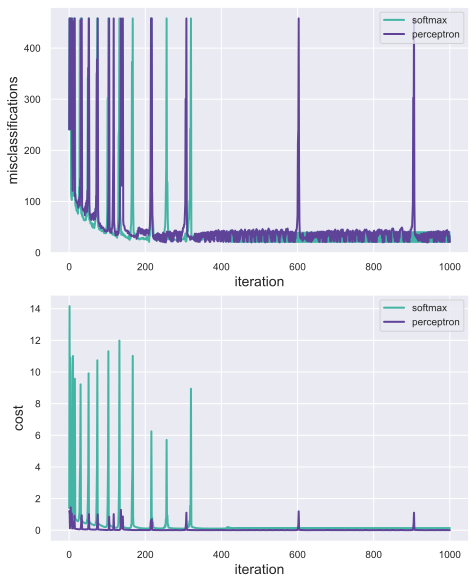

In [132]:
### store data and plot
import pandas as pd

# store plotting data in data frame
plot_data = pd.DataFrame(
    {
        "x_plt": np.arange(np.size(miscount_history_SM)),
        "y_miscount_SM": miscount_history_SM,
        "y_cost_SM": cost_history_SM,
        "y_miscount_PT": miscount_history_PT,
        "y_cost_PT": cost_history_PT
    })

# plot
plot_cost_and_miscount(plot_data)

Below we identify and return the minimum number of misclassifications for each cost function over all iterations of gradient descent.

In [133]:
### identify minima
min_misclass_SM = min(miscount_history_SM)
min_misclass_PT = min(miscount_history_PT)

print("softmax minimum misclassifications:    " + str(min_misclass_SM))
print("perceptron minimum misclassifications: " + str(min_misclass_PT))

softmax minimum misclassifications:    21
perceptron minimum misclassifications: 20


Below we modify the `miscount` function to consider only misclassified malignant cases (i.e., cases corresponding to the class label $-1$).

In [134]:
#### define misclassification rate
import autograd.numpy as np

# compute misclassification history
def miscount_neg(w, x, y):

    # +1 or -1 whether above or below fitted decision bound determined by w
    y_pred = np.sign(model(x, w))

    # consider only malignant cases
    miscount_curr = np.sum(y_pred[y == -1] != -1)
    return miscount_curr

# compute new miscount history for each cost function
miscount_history_SM_neg = [miscount_neg(v, x, y) for v in weight_history_SM]
miscount_history_PT_neg = [miscount_neg(v, x, y) for v in weight_history_PT]

Below we again plot misclassification and cost history side-by-side, this time considering only misclassified malignant cases.

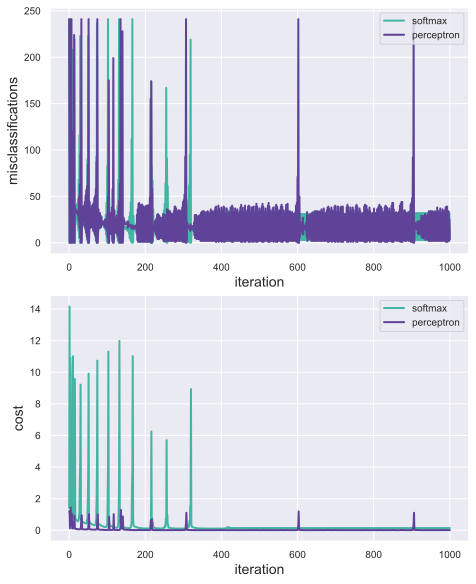

In [135]:
### store data and plot
# import pandas for data frame capabilities
import pandas as pd

# store plotting data in data frame
plot_data = pd.DataFrame(
    {
        "x_plt": np.arange(np.size(miscount_history_SM_neg)),
        "y_miscount_SM": miscount_history_SM_neg,
        "y_cost_SM": cost_history_SM,
        "y_miscount_PT": miscount_history_PT_neg,
        "y_cost_PT": cost_history_PT
    })

# plot
plot_cost_and_miscount(plot_data)

### **1.5** Logistic regression & cross-entropy

In this exercise we compare the above results to those obtained using logistic regression with a cross entropy cost.

The provided code below converts our class labels `y` = $\{-1, 1\}$ to $\{0, 1\}$.

In [136]:
### setup dataset
y_1 = np.squeeze(y) # flatten y (one dimension)

y_ben = np.argwhere(y_1 > 0.9) # returns all indices where y meets condition
y_mal = np.argwhere(y_1 < -0.9)

yc = np.arange(699) # class labels (`y`) for CE (cross-entropy) cost
yc[y_ben] = 1
yc[y_mal] = 0

The code below (provided to us) implements the cross entropy cost function, with L2 regularization.

In [137]:
### define model and cross entropy cost
# define sigmoid function
def sigmoid(t):
    return 1/(1 + np.exp(-t))

## the (convex) cross-entropy cost function
lam = 2*10**(-3) # regularization parameter
def cross_entropy(w):
    # compute sigmoid of model
    sig_eval = sigmoid(model(x, w))

    # compute cost of label 0 points
    ind_mal = np.argwhere(yc == 0)
    cost = -np.sum(np.log(1 - sig_eval[:, ind_mal]))

    # add (subtract) cost on label 1 points
    ind_ben = np.argwhere(yc == 1)
    cost -= np.sum(np.log(sig_eval[:, ind_ben]))

    # add regularizer (* regularization parameter)
    cost += lam*np.sum(w[1:]**2)

    # compute cross-entropy
    return cost/float(np.size(yc))

Below we run gradient descent to optimize the cross entropy cost function for logistic regression.

In [138]:
### optimize cost function using GD
import autograd.numpy as np

# define gradient descent parameters
max_its = 1000
w = 0.1*np.random.randn(9, 1) # initial starting weights

# call GD (choose arb alpha for now bc based on chosen g)
weight_history_CE, cost_history_CE = gradient_descent(cross_entropy, 1,
                                                      max_its, w)

We now compute misclassification history. To do so we must modify `miscount` to compute misclassifications in a manner appropriate to logistic regression. Since the sigmoid function varies between 0 and 1 and is symmetric (about a $180^{\circ}$ rotation centered at $(0, 0.5)$), we can use $y = 0.5$ to effectively separate our predictions into the two classes labelled $\{0, 1\}$. Then, as before, we can determine misclassiffications by comparing the predicted classes across `weight_history` with the true class labels.

In [139]:
### compute misclassification history
import autograd.numpy as np

# compute misclassification history
def miscount_CE(w, x, y):
    y_pred = np.sign(model(x, w))        # 1 or 1 if eval > .5

    # convert predictions to classes based on y = .5 threshold  value
    y_pred[y_pred >= .5]    = 1
    y_pred[y_pred < .5]     = 0

    # pairwise compare vectors: 1 if model class pred == true class; sum
    miscount_curr = np.sum(y_pred != y)

    return miscount_curr

# compute new miscount history for cross entropy cost
miscount_history_CE = [miscount_CE(v, x, yc) for v in weight_history_CE]

And finally, below we plot cost and misclassification history for the logistic regression cross entropy cost, as we did above for the softmax and perceptron cost functions (alongside the results for the perceptron cost function). First we make a couple minor modifications to generalize our plotting function and allow us to plot cross entropy cost in addition to softmax cost.

In [140]:
### define plotting function
def plot_cost_and_miscount(data):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import pandas as pd

    # store data
    x_plt           = data["x_plt"]
    # y_miscount_1    = data["y_miscount_CE"]
    # y_cost_1        = data["y_cost_CE"]
    # y_miscount_2    = data["y_miscount_PT"]
    # y_cost_2        = data["y_cost_PT"]
    y_miscount_1    = data.iloc[:, 1]
    y_cost_1        = data.iloc[:, 2]
    y_miscount_2    = data.iloc[:, 3]
    y_cost_2        = data.iloc[:, 4]

    # use seaborn style
    sns.set_theme()

    # to prevent warning messages from appearing in the report
    import warnings;
    warnings.filterwarnings('ignore')

    # set inline figure format/quality, overall params
    %config InlineBackend.figure_format = 'svg'

    # setup plot & subplots
    fig, axs = plt.subplots(2, 1, figsize = np.array([6.5, 8]),
                            constrained_layout = True) # overall layout, size
    # axs[0] = plt.subplot(1,3,(1,2), frameon = 1)
    axs[0] = plt.subplot(211, frameon = 1)
    axs[1] = plt.subplot(212, frameon = 1)

    # set axis tick sizes
    axs[0].xaxis.set_tick_params(labelsize = font_size - 4)
    axs[0].yaxis.set_tick_params(labelsize = font_size - 4)
    axs[1].xaxis.set_tick_params(labelsize = font_size - 4)
    axs[1].yaxis.set_tick_params(labelsize = font_size - 4)

    # plot overlay of misclassifications & costs for each cost over all it
    line_miscount_CE    = axs[0].plot(x_plt, y_miscount_1,
                                      color = plt_colours[0],
                                      linestyle = '-', linewidth = 2)
    line_miscount_PT    = axs[0].plot(x_plt, y_miscount_2,
                                      color = plt_colours[1],
                                      linestyle = '-', linewidth = 2)
    line_cost_CE        = axs[1].plot(x_plt, y_cost_1,
                                      color = plt_colours[0],
                                      linestyle = '-', linewidth = 2)
    line_cost_PT        = axs[1].plot(x_plt, y_cost_2,
                                      color = plt_colours[1],
                                      linestyle = '-', linewidth = 2)

    # add labels
    # axs[0].set_xlabel('iteration', fontsize = font_size, **font_name)
    axs[0].set_xlabel('iteration', fontsize = font_size)
    axs[0].set_ylabel('misclassifications', fontsize = font_size)
    axs[1].set_xlabel('iteration', fontsize = font_size)
    axs[1].set_ylabel('cost', fontsize = font_size)

    # plot legend
    leg_labels = ['cross entropy', 'perceptron']
    axs[0].legend([line_miscount_CE, line_miscount_PT], labels = leg_labels,
                  loc = 'upper right', frameon = 1, fontsize = font_size - 4)
    axs[1].legend([line_cost_CE, line_cost_PT], labels = leg_labels,
                  loc = 'upper right', frameon = 1, fontsize = font_size - 4)

    plt.show()

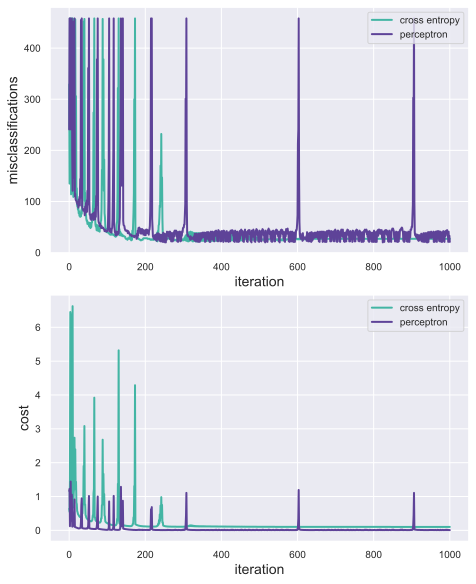

In [141]:
### store data and plot
import pandas as pd

# store plotting data in data frame
plot_data = pd.DataFrame(
    {
        "x_plt": np.arange(np.size(miscount_history_CE)),
        "y_miscount_CE": miscount_history_CE,
        "y_cost_CE": cost_history_CE,
        "y_miscount_PT": miscount_history_PT,
        "y_cost_PT": cost_history_PT
    })

# plot
plot_cost_and_miscount(plot_data)

## **Exercise 2** *Spam detection* {-}

In this problem we examinine the [Spambase Data Set](https://archive.ics.uci.edu/ml/datasets/Spambase) [^1], containing measurements of spam and non-spam emails. Using the two-class classification methods we explored in the above exercises, we build a classifier to determine if an email is likely to be spam.

[^1]: Frank, A. (2010). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.

*notes*

Class labels (1 for 'spam', -1 for 'not spam') are again stored in the final row ($N = 58$) of the dataset, with each other row $n$ representing a feature (word/character frequencies, etc.) and each column $p$ a sample ($P = 4601$).

Below we import the dataset.

In [142]:
### import dataset
import numpy as np

# data input
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/PHYS 3G03/' \
    '3G0-assignments/HW 3/code/'
csvname = datapath + 'spambase_data.csv'
data = np.loadtxt(csvname, delimiter = ',')

# get input and output of dataset
x = data[:-1, :]    # feature vectors
y = data[-1:, :]    # class labels {1,-1}

**Some basic preprocessing**

We now perform some preprocessing to prepare the dataset for our analysis. We standard normalize each feature (s.t. $\mu_n = 0$ and $\sigma_n = 1$, where $\mu$ represents the mean and $\sigma$ the standard deviation) so that they can be treated equally by our classifier. To do so, for each observation $x_{n,p}$ we subtract the corresponding mean $\mu_n$ and divide by the corresponding standard deviation $\sigma_n$.

To deal with missing observations for a given feature (represented as `NaN`), we replace `NaN` with the corresponding feature mean $\mu_n$.

The following function (provided to us) executes the above.

In [143]:
### perform standard normalization and fill in missing data
def standard_normalizer(x):

    # compute the mean and standard deviation of each feature
    x_means = np.nanmean(x, axis = 1)[:, np.newaxis]
    x_stds  = np.nanstd(x, axis = 1)[:, np.newaxis]

    # check to make sure that x_stds > small threshold; for those not
    # divide by 1 instead of original standard deviation
    ind = np.argwhere(x_stds < 10**(-2))
    if len(ind) > 0:
        ind = [v[0] for v in ind] # just keep row index
        adjust = np.zeros((x_stds.shape)) # array of indices to replace with 1
        adjust[ind] = 1.0
        x_stds += adjust

    # fill in any nan values with corresponding feature mean
    ind = np.argwhere(np.isnan(x) == True)
    for i in ind:
        x[i[0], i[1]] = x_means[i[0]]

    # create standard normalizer function
    normalizer = lambda data: (data - x_means)/x_stds

    # create inverse standard normalizer
    inverse_normalizer = lambda data: data*x_stds + x_means

    # return (inverse) normalizer
    return normalizer, inverse_normalizer

## standard normalize dataset
normalizer, inverse_normalizer = standard_normalizer(x) # get std norm functions
x = normalizer(x)

### **2.1** Email classification with softmax and perceptron {-}

In this exercise we classify emails using the softmax and perceptron cost functions.

**Steps:**

We carry out the same sequence of steps covered in detail in exercise 1:

1. Identify optimal decision boundary (determined by weights $w$):
   - run gradient descent to identify $w$ that minimizes cost functions
   - softmax: $\alpha = 1.0$; perceptron: $\alpha = 0.1$
   - other parameters: `max its = 1000`; `w = 0.1*np.random.randn(N + 1, 1)`, where $N = 57$
2. Compute misclassification histories
3. Plot cost and misclassification as a function of gradient descent iteration

In [144]:
### 1) optimize softmax and perceptron costs over `spambase` dataset
import autograd.numpy as np

# define gradient descent parameters
max_its = 1000
w = 0.1*np.random.randn(np.shape(x)[0] + 1, 1) # initial starting weights

# call GD (choose arb alpha for now bc based on chosen g)
weight_history_SM_spam, cost_history_SM_spam = gradient_descent(softmax, 1,
                                                        max_its, w)
weight_history_PT_spam, cost_history_PT_spam = gradient_descent(perceptron, 1,
                                                        max_its, w)

In [145]:
### 2) compute misclassification history for each cost function
miscount_history_SM_spam = [miscount(v, x, y) for v in weight_history_SM_spam]
miscount_history_PT_spam = [miscount(v, x, y) for v in weight_history_PT_spam]

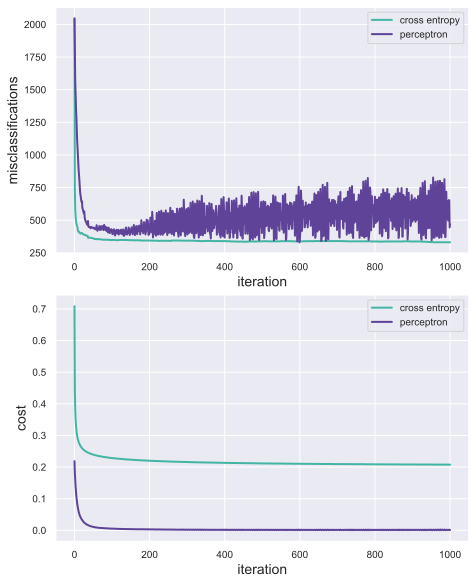

In [146]:
### 3) for each cost, plot cost and misclassification as a function of iteration
## store data and plot
import pandas as pd

# store plotting data in data frame
plot_data = pd.DataFrame(
    {
        "x_plt": np.arange(np.size(miscount_history_SM_spam)),
        "y_miscount_SM": miscount_history_SM_spam,
        "y_cost_SM": cost_history_SM_spam,
        "y_miscount_PT": miscount_history_PT_spam,
        "y_cost_PT": cost_history_PT_spam
    })

## plot
plot_cost_and_miscount(plot_data)

The plots above reveal some interesting results. The perceptron cost appears to attain a stable minimum cost, but its misclassification history appears to fluctuate rapidly between ~250 and 750 misclassifications. On the other hand, the softmax cost appears to attain a stable, albeit higher, minimum cost, but its misclassification history reaches a similar minimum to the softmax cost and is stable (does not fluctate rapidly). This suggests that the perceptron cost function is not perfectly flat at the identified minimum, causing minor perturbations in weight to produce large deviations from the minimum. It is possible that different (non-standard) gradient descent schemes (e.g., fully normalized) would eliminate this behaviour. 

### **2.2** Accuracy {-}

In this exercise we determine the misclassification minimum and convert it to accuracy.

*Recall*: we define accuracy, $\mathcal{A}$ as

$$
\mathcal{A} = 1 - \frac{1}{P} \sum\limits_{p = 1}^P I(\hat{y}_p, y_p) ,
$$

where $\sum\limits_{p = 1}^P I$ represents total misclassifications, which we average over all samples $P$ and subtract from 1.

In [147]:
### determine minimum misclassifications for each cost and convert to accuracy
# identify minima
min_misclass_SM_spam = min(miscount_history_SM_spam)
min_misclass_PT_spam = min(miscount_history_PT_spam)

print("softmax minimum misclassifications:    " + str(min_misclass_SM_spam))
print("perceptron minimum misclassifications: " + str(min_misclass_PT_spam))

# convert to accuracies
accuracy_SM_spam = 1 - (min_misclass_SM_spam)/np.shape(x)[1]
accuracy_PT_spam = 1 - (min_misclass_PT_spam)/np.shape(x)[1]

print("\nsoftmax accuracy:    " + str(accuracy_SM_spam))
print("perceptron accuracy: " + str(accuracy_PT_spam))

softmax minimum misclassifications:    331
perceptron minimum misclassifications: 330

softmax accuracy:    0.9280591175831341
perceptron accuracy: 0.9282764616387742


As we can see above, both classifiers, trained using a softmax and perceptron cost, respectively, appear to perform relatively well, with accuracies above 90%. However, softmax cost performs slighly better, with 3 fewer misclassifications than the perceptron. This result reflects our expectations based on the misclassification and cost histories plotted above.

### **2.3** Confusion matrix {-}

In this exercise we identify the optimal `w` found by the softmax cost and construct the corresponding confusion matrix [^1].

[^1]: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

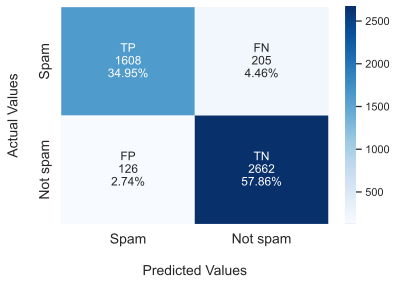

In [148]:
### construct confusion matrix for optimal softmax `w`
## define model again (compute linear combination of input points)
def model(x, w):
    a = w[0] + np.dot(x.T, w[1:])
    return a.T

## identify optimal `w` for cost
w_optimal_SM_spam = weight_history_SM_spam[np.argmin(miscount_history_SM_spam)]
# w_optimal_PT_spam = weight_history_PT_spam[np.argmin(miscount_history_PT_spam)]

### function for plotting confusion matrix
def plot_confusion_matrix(w, x, y):

    import seaborn as sns
    import pandas as pd
    import numpy as np

    # +1 or -1 whether above or below fitted decision bound determined by w
    y_pred = np.sign(model(x, w))

    ## determine confusion matrix values (true pos/neg, false pos/neg)
    TP = np.sum(y_pred[y == 1] == 1)
    TN = np.sum(y_pred[y == -1] == -1)
    FP = np.sum(y_pred[y == -1] != -1)
    FN = np.sum(y_pred[y == 1] != 1)

    # store values in dictionary, matrix for plotting
    confusion_matrix_OP = {"TP": TP, "TN": TN, "FP": FP, "FN": FN}
    # confusion_matrix_OP["TN"] = TN
    conf_matrix = np.array([[TP, FN],
                            [FP, TN]])

    ## plot confusion matrix
    # set annotations for tiles based on counts
    group_names = ['TP', 'FN', 'FP', 'TN']
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         conf_matrix.flatten()/np.sum(conf_matrix)]

    tile_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
                   zip(group_names, group_counts, group_percentages)]
    tile_labels = np.asarray(tile_labels).reshape(2, 2)

    # plot
    ax = sns.heatmap(conf_matrix, annot = tile_labels, fmt = '', cmap = 'Blues')

    # labels
    ax.set_xlabel('\nPredicted Values', fontsize = font_size)
    ax.set_ylabel('Actual Values\n', fontsize = font_size);
    ax.xaxis.set_ticklabels(['Spam', 'Not spam'], fontsize = font_size)
    ax.yaxis.set_ticklabels(['Spam', 'Not spam'], fontsize = font_size)

    plt.show()

    return confusion_matrix_OP

## plot confusion matrix for softmax and optimal weight
confusion_matrix = plot_confusion_matrix(w_optimal_SM_spam, x, y)

## **Exercise 3** *Credit check* {-}

In this problem we examinine a dataset containing credit ratings, described in Example 6.11 of *Machine Learning Refined* [^1].

[^1]: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.

*notes*

Class labels (1 for 'good rating', -1 for 'bad rating') are again stored in the final row of the dataset ($N = 20$), with each other row $n$ representing a feature (account balance, duration of previous credit, etc.) and each column $p$ a sample ($P = 1000$).

Below we import the dataset.

3.3 Determine the confusion matrix for the optimal weights determined with the perceptron cost.

In [149]:
### import dataset
import numpy as np

# data input
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/PHYS 3G03/' \
    '3G0-assignments/HW 3/code/'
csvname = datapath + 'credit_dataset.csv'
data = np.loadtxt(csvname, delimiter = ',')

# get input and output of dataset
x = data[:-1, :]    # feature vectors
y = data[-1:, :]    # class labels {1,-1}

### **3.1** Standard normalization {-}

Below we standard normalize the dataset so that features can be compared.

In [150]:
### perform standard normalization
normalizer, inverse_normalizer = standard_normalizer(x) # get std norm functions
x = normalizer(x)

### **3.2** Fitting perceptron-based classifier {-}

Below we fit a binary classifier using a perceptron cost.

In [151]:
### optimize perceptron cost over `credit rating` dataset
import autograd.numpy as np

# define gradient descent parameters
max_its = 1000
w = 0.1*np.random.randn(np.shape(x)[0] + 1, 1) # initial starting weights

# call GD (choose arb alpha for now bc based on chosen g)
weight_history_PT_cred, cost_history_PT_cred = gradient_descent(perceptron, 1,
                                                        max_its, w)

In [152]:
### compute misclassification history
miscount_history_PT_cred = [miscount(v, x, y) for v in weight_history_PT_cred]

In [153]:
### store data for plotting
import pandas as pd

# store plotting data
x_plt = np.arange(np.size(miscount_history_PT_cred))
y_miscount_PT = miscount_history_PT_cred
y_cost_PT = cost_history_PT_cred

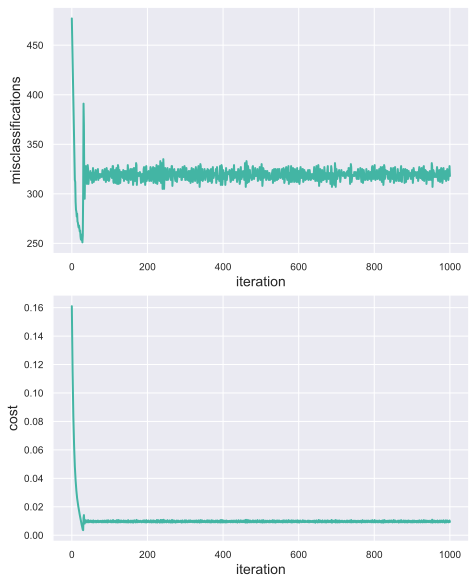

In [154]:
### plot cost and misclassification history for perceptron cost
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# use seaborn style
sns.set_theme()

# to prevent warning messages from appearing in the report
import warnings;
warnings.filterwarnings('ignore')

# set inline figure format/quality, overall params
%config InlineBackend.figure_format = 'svg'

# setup plot & subplots
fig, axs = plt.subplots(2, 1, figsize = np.array([6.5, 8]),
                        constrained_layout = True) # overall layout, size
# axs[0] = plt.subplot(1,3,(1,2), frameon = 1)
axs[0] = plt.subplot(211, frameon = 1)
axs[1] = plt.subplot(212, frameon = 1)

# set axis tick sizes
axs[0].xaxis.set_tick_params(labelsize = font_size - 4)
axs[0].yaxis.set_tick_params(labelsize = font_size - 4)
axs[1].xaxis.set_tick_params(labelsize = font_size - 4)
axs[1].yaxis.set_tick_params(labelsize = font_size - 4)

# plot overlay of misclassifications & costs for each cost over all it
line_miscount_CE    = axs[0].plot(x_plt, y_miscount_PT,
                                  color = plt_colours[0],
                                  linestyle = '-', linewidth = 2)
line_cost_CE        = axs[1].plot(x_plt, y_cost_PT,
                                  color = plt_colours[0],
                                  linestyle = '-', linewidth = 2)

# add labels
# axs[0].set_xlabel('iteration', fontsize = font_size, **font_name)
axs[0].set_xlabel('iteration', fontsize = font_size)
axs[0].set_ylabel('misclassifications', fontsize = font_size)
axs[1].set_xlabel('iteration', fontsize = font_size)
axs[1].set_ylabel('cost', fontsize = font_size)

plt.show()

In [155]:
### compute and output perceptron accuracy
min_misclass_PT_cred = min(miscount_history_PT_cred)
accuracy_PT_cred = 1 - (min_misclass_PT_cred)/np.shape(x)[1]
print("perceptron accuracy: " + str(accuracy_PT_cred))

perceptron accuracy: 0.749


The perceptron achieves a classification accuracy of ~76%, which is within the range of the accuracy achieved in *Machine Learning Refined*.

### **3.3** Confusion matrix {-}

We now plot the confusion matrix corresponding to the optimal weight identified by the perceptron.

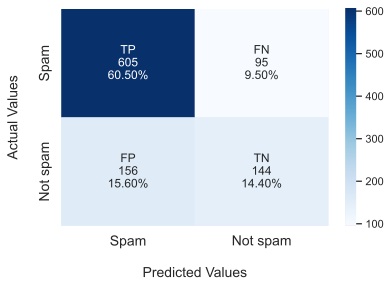

In [156]:
### plot confusion matrix for perceptron and optimal weight
w_optimal_PT_cred = weight_history_PT_cred[np.argmin(miscount_history_PT_cred)]
confusion_matrix = plot_confusion_matrix(w_optimal_PT_cred, x, y)

## **Exercise 4** *Three-class classification* {-}

In this problem we examinine a three-class toy dataset, shown in Fig. 7.9 of *Machine Learning Refined* [^1], using the multi-class perceptron. Additional resources (including plotting functions) are provided in the official 'MLR' git repository [^2].

[^1]: Watt, J., Borhani, R., & Katsaggelos, A. K. (2020). Machine learning refined: Foundations, algorithms, and applications. Cambridge University Press.
[^2]: https://github.com/jermwatt/machine_learning_refined/tree/gh-pages/notes/7_Linear_multiclass_classification

### **4.1** Fitting multi-class perceptron {-}

Below we fit the multi-class perceptron to the dataset.

In [157]:
### import dataset & standard normalize
import numpy as np

# data input
datapath = '/Users/matthewbain/Documents/Math/courses/semester II/PHYS 3G03/' \
    '3G0-assignments/HW 3/code/'
csvname = datapath + '3class_data.csv'
data = np.loadtxt(csvname, delimiter = ',')

# get input and output of dataset
x = data[:-1, :]    # feature vectors
y = data[-1:, :]    # class labels {1,-1}

## normalize
normalizer, inverse_normalizer = standard_normalizer(x) # get std norm functions
x = normalizer(x)

In [158]:
### define model and multi-class perceptron (*provided code*)
## compute C linear combinations of input point, one per classifier
def model(x, w):
    a = w[0] + np.dot(x.T, w[1:])
    return a.T

## multi-class perceptron
lam = 10**-5  # regularization paramter
def multiclass_perceptron(w):

    # pre-compute predictions on all points
    all_evals = model(x, w)

    # compute maximum across data points
    a = np.max(all_evals, axis = 0)

    # compute cost in compact form using numpy broadcasting
    b = all_evals[y.astype(int).flatten(), np.arange(np.size(y))]
    cost = np.sum(a - b)

    # add regularizer
    cost = cost + lam*np.linalg.norm(w[1:, :], 'fro')**2

    # return average
    return cost/float(np.size(y))

In [159]:
### fit multi-class perceptron
import autograd.numpy as np

# define gradient descent parameters
max_its = 1000
w = 0.1*np.random.randn(3, 3) # initial starting weights

# call GD (choose arb alpha for now bc based on chosen g)
weight_history_3CPT, cost_history_3CPT = gradient_descent(
    multiclass_perceptron, .1, max_its, w)

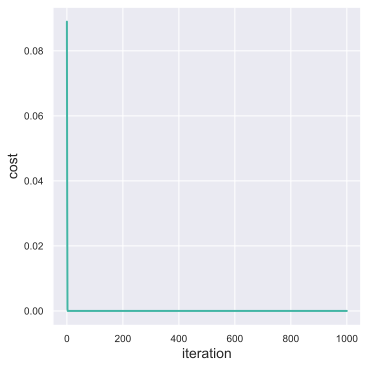

In [160]:
### plot cost history
## store data
x_plt = np.arange(np.shape(weight_history_3CPT)[0])
y_cost_3CPT = cost_history_3CPT

## plot
def plot_cost_history(x, y):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    import pandas as pd

    # use seaborn style
    sns.set_theme()

    # setup plot
    fig, ax = plt.subplots(1, 1, figsize = np.array([5, 5]),
                            constrained_layout = True) # overall layout, size
    ax = plt.subplot(111, frameon = 1)

    # set axis tick sizes
    ax.xaxis.set_tick_params(labelsize = font_size - 4)
    ax.yaxis.set_tick_params(labelsize = font_size - 4)

    # plot cost history
    y_cost_3CPT = ax.plot(x, y, color = plt_colours[0],
                        linestyle = '-', linewidth = 2)

    # add labels
    ax.set_xlabel('iteration', fontsize = font_size)
    ax.set_ylabel('cost', fontsize = font_size)

    plt.show()

plot_cost_history(x_plt, y_cost_3CPT)

In [161]:
weight_history_3CPT[1]
model(x, w)
np.shape(model(x, w))

all_evals = model(x, weight_history_3CPT[1])
np.shape(all_evals)
np.shape(np.max(all_evals, axis = 0))

(30,)

In [162]:
### define new function to compute multi-class misclassification history
def miscount_3CPT(w, x, y):
    # 0-2 based on weight that maximizes prediction
    # y_pred = np.argmax(np.abs(model(x, w), axis = 0), axis = 0)
    
    # compute prediction for all points
    all_evals = model(x, w)

    # assign point class of DB that maximumizes distance to DB
    y_pred = np.argmax(all_evals, axis = 0)
        
    # pairwise compare vectors: 1 if model class pred == true class; sum
    miscount_curr = np.sum(y_pred != y)
    return miscount_curr

In [163]:
### compute accuracy for optimal weight (minimum misclassifications)
# compute misclassifications
miscount_history_3CPT = [miscount_3CPT(v, x, y) for v in weight_history_3CPT]

# find minimum misclassifications and convert to accuracy
min_misclass_3CPT = min(miscount_history_3CPT)
print("multi-class perceptron minimum misclassifications: "
      + str(min_misclass_3CPT))

# convert to accuracies
accuracy_3CPT = 1 - (min_misclass_3CPT)/np.shape(x)[1]

print("multi-class perceptron accuracy: " + str(accuracy_3CPT))

multi-class perceptron minimum misclassifications: 0
multi-class perceptron accuracy: 1.0


"Can you achieve as good a classification as shown in Fig. 7.9 in the book ?"

### **4.2** Plotting the decision boundary {-}

Below we plot the data in the plane, along with the decision boundary obtained by the multi-class perceptron.

In [164]:
# code to clone library from git repo subdirectory
# (from Ciro Santilli @ https://stackoverflow.com/questions/600079/how-do-i-clone-a-subdirectory-only-of-a-git-repository)
# git clone \
#     --depth 1  \
#     --filter=blob:none  \
#     --sparse \
#     https://github.com/jermwatt/machine_learning_refined \
# ;
# cd machine_learning_refined
# git sparse-checkout set mlrefined_libraries

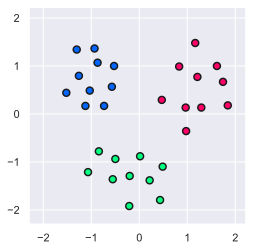

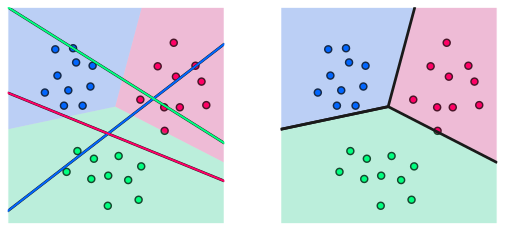

In [165]:
### plot data and decision boundary
# import relevant MLR plotting libraries (store lib in current dir)
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

optimizers      = optlib.optimizers
classif_plotter = superlearn.multi_lin_classification_demo
cost_lib        = superlearn.cost_functions
normalizers     = superlearn.normalizers

# store std. normalized dataset to pass to function (colours = class labels)
data_norm = np.append(x, y, axis = 0)
data_norm[-1,0] = 0

# plot individual data points in plane
demo = superlearn.multiclass_illustrator.Visualizer(data_norm)
demo.show_dataset()

# add DBs (pass weights defining 3 class DBs that give perfect accuracy)
demo.show_complete_coloring([weight_history_3CPT[-1]], cost = 
                            multiclass_perceptron)

The multi-class perceptron achieves a classification accuracy of 100%, yielding results that are comparable to those shown in *Machine Learning Refined*.